# Evaluating Agents with SageMaker AI and Comet Opik

This notebook demonstrates how to build, track, and evaluate agents using SageMaker AI endpoints, CrewAI agents, and Comet Opik
for evaluation.

What you'll learn:
- Setting up a SageMaker AI Jumpstart Endpoint
- Using the CrewAI Framework to define a market research agent
- Tracing the Agent with Comet Opik


### Install dependancies

In [ ]:
%pip install -Uq crewai crewai-tools opik

In [ ]:
#Import all the packages we will be using
import opik
import os
import getpass
from crewai import Agent, Crew, Task, Process, LLM
from opik.integrations.crewai import track_crewai

### Setup the Comet Opik environment for the SageMaker Partner AI Apps deployment

In [ ]:
# For SageMaker Studio -> Partner AI Apps -> Comet -> View Details
# For SageMaker Unified Studio -> Build -> Partner AI Apps -> Comet -> View Details
# Grab the SDK URL (Opik) and ARN from Details page to use below

import json
import sagemaker
import boto3
import os
from datetime import datetime

os.environ["AWS_PARTNER_APP_AUTH"] = "true"
os.environ["AWS_PARTNER_APP_ARN"] = "" # View Details -> ARN
os.environ["COMET_API_KEY"] = "" # From Details Page, click Open Comet. In the top right corner, click on User icon -> API Key
os.environ["OPIK_API_KEY"] = os.environ["COMET_API_KEY"] # Opik API Key is the same as the Comet API Key
os.environ["OPIK_URL_OVERRIDE"] = "" # From Details Page, copy the SDK URL (Opik)
os.environ["OPIK_WORKSPACE"] = "" # From Details Page, click Open Comet. In the top right corner, click on the Try Opik button. Click on User icon -> Workspace -> copy the Workspace name.

#Configure the Opik API key
opik.configure(use_local=False)

opik_project_name = "Opik-Recipe-Agent-Eval"


### Set up the model for the CrewAI agent

CrewAI can natively integrate with SageMaker AI Jumpstart models. First we will deploy a Jumpstart model and configure CrewAI to use this for our agent. Here we are going to use the Meta Llama 3.1 8B.

In [ ]:
def check_endpoint_exists(endpoint_name):
    """
    Check if a SageMaker endpoint with the given name already exists.
    
    Args:
        endpoint_name (str): The name of the endpoint to check
        
    Returns:
        bool: True if endpoint exists, False otherwise
    """
    client = boto3.client('sagemaker')
    
    try:
        # Try to describe the endpoint, if it exists this will succeed
        client.describe_endpoint(EndpointName=endpoint_name)
        print(f"Endpoint '{endpoint_name}' already exists")
        return True
    except client.exceptions.ClientError as e:
        # If the endpoint doesn't exist, we'll get a ClientError
        if "Could not find endpoint" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist")
            return False
        # If it's a different error, re-raise it
        raise e

def create_jumpstart_endpoint(endpoint_name, model_id, model_version):
    """
    Create a SageMaker JumpStart model endpoint with the specified name.
    
    Args:
        endpoint_name (str): The name to give the endpoint
        model_id (str): The JumpStart model ID (e.g., 'huggingface-text2text-flan-t5-base')
        instance_type (str): The instance type to use for deployment
        
    Returns:
        sagemaker.jumpstart.model.JumpStartModel: The deployed model
    """
    # Initialize a SageMaker session
    session = sagemaker.Session()
    
    # Create a JumpStart model
    model = JumpStartModel(
        model_id=model_id, 
        model_version=model_version
    )
    
    # Deploy the model to the specified endpoint name
    predictor = model.deploy(
        accept_eula=accept_eula,
        endpoint_name=endpoint_name
    )
    predictor = model.deploy(
        initial_instance_count=1,
        # instance_type=instance_type, #Optionally can change instance type
        endpoint_name=endpoint_name
    )
    
    print(f"Successfully deployed endpoint '{endpoint_name}' using JumpStart model '{model_id}'")
    return model

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel

# Example model_id, replace with your desired JumpStart model
endpoint_name = "deepseek-llm-r1-distill-llama-70b"
model_id, model_version = endpoint_name, "*"

accept_eula = True # need to change this to True to deploy
model = JumpStartModel(model_id=model_id, model_version=model_version)
    
# Check if endpoint exists
if not check_endpoint_exists(endpoint_name):
    # Create the endpoint if it doesn't exist
    model = create_jumpstart_endpoint(endpoint_name, model_id, model_version)
    
    # Example of how to use the endpoint
    print(f"You can now use the endpoint '{endpoint_name}' for inference")
else:
    # Endpoint already exists
    print(f"Using existing endpoint '{endpoint_name}'")
    # If you want to get a predictor for an existing endpoint:
    predictor = sagemaker.Predictor(
        endpoint_name=endpoint_name,
        sagemaker_session=sagemaker.Session(),
        serializer=sagemaker.serializers.JSONSerializer(),
        deserializer=sagemaker.deserializers.JSONDeserializer()
    )
    print("Predictor created for existing endpoint")

Next we'll define the LLM configuration for the CrewAI agent

In [ ]:
model_config = "sagemaker/" + predictor.endpoint_name

llm = LLM(
    model=model_config
)

In [ ]:
from crewai import Agent, Crew, Task

class RecipeAgent:
    def __init__(self,suggest_task_description=None, research_task_description=None):
        if suggest_task_description:
            self.suggest_task_description = suggest_task_description
        else:
            self.suggest_task_description = """Given the following list of ingredients, suggest a creative recipe.

            Create a unique recipe that all of the provided ingredients in an innovative way and creative. Do your best to avoid ingredients that are not in the ingredients list beyond cooking essentials.
            Provide the recipe name, a complete ingredient list with measurements, and step-by-step instructions.

            Ingredients: {ingredients_list}"""

        if research_task_description:
            self.research_task_description = research_task_description
        else:
            self.research_task_description = """Based on the recipe provided in the context, research and provide a concise summary of relevant information about this specific recipe.

            Focus on:
            - Practical cooking tips specific to this recipe
            - Possible variations or ingredient substitutions
            - Troubleshooting common problems people might encounter and how to solve them

            Only provide information relevant to the specific recipe mentioned in the context.
            """

    # --- Agent 1: Recipe Suggester ---
    def recipe_suggester(self) -> Agent:
        return Agent(
            role="Chef",
            goal="Suggest a creative recipe",
            backstory="An experienced and helpful chef who creates innovative recipes",
            verbose=False,
            llm=llm,
        )

    # --- Agent 2: Recipe Researcher ---
    def recipe_researcher(self) -> Agent:
        return Agent(
            role="Culinary research assistant",
            goal="Provide useful and relevant recipe information",
            backstory="A diligent researcher and culinary expert with a keen eye for detail",
            verbose=False,
            llm=llm,
        )

    # --- Crew Configuration ---
    def crew(self) -> Crew:
        # Create agents
        suggester = self.recipe_suggester()
        researcher = self.recipe_researcher()

        suggest_task = Task(
            name="Suggest Recipe",
            description=self.suggest_task_description,
            expected_output="""A clear, neatly formatted recipe in the format:
                Recipe Name:
                Ingredients:
                Instructions: """,
            agent=suggester
        )

        research_task = Task(
            name="Research Recipe",
            description=self.research_task_description,
            expected_output="""A clear, concise, neatly formatted research summary in the format:
                Cooking Tips:
                Variations:
                Troubleshooting:
                """,
            agent=researcher,
            context=[suggest_task],
        )

        return Crew(
            agents=[suggester, researcher],
            tasks=[suggest_task, research_task],
            process=Process.sequential,
            verbose=False,
        )

    # --- Helper methods to work with structured outputs ---
    def run_crew(self, ingredients_list: str):
        """Run the crew and return structured outputs"""
        crew = self.crew()
        result = crew.kickoff(inputs={"ingredients_list": ingredients_list})

        # Access individual task outputs
        recipe_output = result.tasks_output[0].raw
        research_output = result.tasks_output[1].raw

        return {
            "recipe": recipe_output,
            "research": research_output,
        }



### Evaluating your Agent

#### Start with observability
To start evaluating and improving our agent, we first need visibility into what our agent is doing.  We can start tracking the agent easily through Opik’s CrewAI integration.  By running track_crewai, we automatically start logging everything the agent does.  
Once we instantiate and run the crew, we’ll be able to see the trace in the Opik UI.


In [ ]:
from opik.integrations.crewai import track_crewai

track_crewai(project_name=opik_project_name)
agent = RecipeAgent()
result = agent.run_crew("cold pizza, bananas, honey")

Once we instantiate and run the crew, we’ll be able to see the trace in the Opik UI.

![View trace in Opik](./images/recipe_agent_trace.gif)

#### Create an evaluation dataset
Visibility into our agent’s traces enables us to spot check our agent’s behavior, but to really understand its performance, we’ll need a more systematic approach.  That’s where evaluation datasets and experiments come into play.  We need to know how well our agent will perform at scale, so we’ll need to test it on a variety of inputs.  

We’ll start by creating an empty dataset  using the opik client.


In [ ]:
from opik import Opik

# Get or create a dataset
opik_dataset_name = "RecipeAgentEval"
client = Opik(project_name=opik_project_name)
dataset = client.get_or_create_dataset(name=opik_dataset_name)

Next we’ll create some example inputs, which we will use to test our agent’s performance during evaluation.  In this case, we’ll use five made-up examples.  However, in a real-world use case, a larger evaluation dataset is preferred to confidently evaluate agent performance. 

For this example, we only need inputs to evaluate our agent.  Depending on the evaluation metrics

In [ ]:
eval_inputs = [
    "squash, cauliflower, pasta, tomatoes, parmesan cheese",
    "strawberries, basil, pickles, bread crumbs, apple sauce",
    "croutons, paprika, carrots, rice",
    "stale bread, frozen peas, walnuts, milk, apricots",
    "orange juice, cranberries, crackers, tomato paste, chickpeas"
]
json_inputs = [{"input": i} for i in eval_inputs]

dataset.insert(json_inputs)

You can also add logged traces to a dataset from the Opik UI.

![][image1]

[image1]: <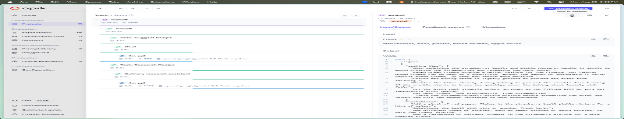>

#### Define Evaluation Metrics

We’ll be using LLM-as-Judge metrics to evaluate our agent, so our first step is to select an evaluation model, an LLM which will be specifically prompted to judge our agent’s performance. For this example we’ll be using an Amazon SageMaker model.  

In [ ]:
from opik.evaluation.metrics import GEval

# The model to be used for LLM-as-a-Judge evaluation
eval_model = "sagemaker/" + predictor.endpoint_name

Next we will define our actual metrics.  Opik supports a number of built-in and custom metrics for AI agents.  For this example we’ll use G-eval, a customizable LLM-as-Judge metric that uses  Chain of Thought prompting to score how well an agent adheres to the specified criteria.  We’ll define three custom G-Eval metrics for our agent.:
Recipe relevance:  How relevant is the recipe our agent suggested to the ingredients list input by the user?  A low score means that the suggested recipe uses ingredients that do not match the user’s input, while a high score indicates that the suggested recipe perfectly matches the input ingredients list.
Recipe realism:  How realistic is the suggested recipe? Could it actually be cooked by an everyday user? Would someone realistically want to cook this recipe?
Research relevance: How relevant is the research (done by the Recipe Researcher agent) to the recipe that was suggested by the Recipe Suggester agent? Does the response stay focused on the suggested recipe, or does it mention other recipes, general cooking information, or otherwise go off-topic?

For each metric, we define a task introduction prompt, and a list of criteria.  Note that each evaluation metric is specific to an aspect of one of our agent’s tasks.  The criteria specifically reference the inputs and outputs for the task in question.  That way, we can pinpoint exactly where in the system failures are occurring.

The first two metrics will evaluate the agent’s recipe suggestion:


In [ ]:
# --- Recipe Suggester Metrics ---

recipe_relevance_metric = GEval(
    model=eval_model,
    name='g_eval_recipe_relevance',
    task_introduction="You are an expert judge tasked with evaluating the relevance of an AI-generated recipe to the ingredients list in the INPUT provided by a user. Only evaluate the 'recipe' section of the OUTPUT.  Ignore the 'research' section of the OUTPUT and do not include it in your evaluation",
    evaluation_criteria="""
    The recipe in the OUTPUT must use most or all of the ingredients provided in the INPUT.
    The recipe in the OUTPUT may exclude a maximum of one ingredient in the INPUT.
    The recipe in the OUTPUT may only use ingredients that are not in the INPUT ingredients list if they are considered basic cooking essentials or ingredients a user would be likely to have available at home.
    """
)

recipe_realism_metric = GEval(
    model=eval_model,
    name='g_eval_recipe_realism',
    task_introduction="You are an expert culinary judge tasked with evaluating how realistic and AI-generated recipe is. Only evaluate the 'recipe' section of the OUTPUT.  Ignore the 'research' section of the OUTPUT and do not include it in your evaluation",
    evaluation_criteria="""
    The recipe in the OUTPUT may be unusual or creative, but it must be a realistic recipe that could actually be cooked by an everyday user.
    The recipe in the OUTPUT may be unusual or creative, but it must be a recipe that a user would actually want to cook and eat.
    """
)

The last metric will evaluate the agent’s recipe research:

In [ ]:
# --- Recipe Researcher Metrics ---

research_relevance_metric = GEval(
    model=eval_model,
    name='g_eval_research_relevance',
    task_introduction="You are an expert judge tasked with evaluating the relevance of a research summary to the recipe suggested in the input.",
    evaluation_criteria="""
    The research in the OUTPUT must only include information related to the specific recipe provided in the OUTPUT.
    """,
)

#### Run the evaluation
Now that we have defined metrics, we’ll set an evaluation task.  This function will run against each item in our evaluation dataset. The purpose of this step is to run the execution flow and map out the inputs and outputs to be evaluated.


In [ ]:
from opik.evaluation import evaluate

# Define the evaluation task
def eval_recipe_agent(dataset_item):
    # your LLM application is called here
    agent = RecipeAgent()
    agent_output = agent.run_crew(dataset_item['input'])
    return {
        "input": dataset_item['input'],
        "output": agent_output,
    }

Finally we’ll run the evaluation as an experiment.  We’ll provide an experiment name, our evaluation dataset, the evaluation task we defined above, and our custom scoring metrics. In this example, we are logging our evaluation traces to the same project in Opik.  Alternatively, you may log evaluation traces to a different project or to the default project.


In [ ]:
# Run the evaluation
eval_1 = evaluate(
    experiment_name='recipe_agent_exp_1',
    dataset=dataset,
    task=eval_recipe_agent,
    scoring_metrics=[recipe_relevance_metric, recipe_realism_metric, research_relevance_metric],
    project_name=opik_project_name # project name where evaluation traces will appear
)

#### Review experiment results in Opik

![View experiment in Opik](./images/view_experiment.gif)

#### Improve the Agent
When you review your agent results in Opik, you may find that this agent isn’t performing so well on the recipe realism metric.  We may be able to improve this by adjusting the task description for the suggest task.  The current task description instructs the agent to suggest a “creative recipe” and to try to use all of the ingredients in an innovative way.  Let’s adjust the prompt to encourage the agent to be a little bit more realistic.  


In [ ]:
new_suggest_task_description = """Given the following list of ingredients, suggest a creative, yet realistic recipe.

            Create a recipe that uses most or all of the provided ingredients. Do your best to avoid ingredients that are not in the ingredients list beyond basics that a user is likely to have at home. Make sure that the recipe is something that someone would actually want to eat.
            Provide the recipe name, a complete ingredient list with measurements, and step-by-step instructions.

            Ingredients: {ingredients_list}"""

agent_2 = RecipeAgent(suggest_task_description=new_suggest_task_description)
result = agent.run_crew("cold pizza, bananas, honey")

Now we can run a second experiment to test the updated agent. We’ll define a new evaluation task, using an agent with the updated task description.  Then we’ll run another evaluation, using a different experiment name so that we can compare results easily in the Opik UI.


In [ ]:
# Define another evaluation task for the updated agent
def eval_recipe_agent(dataset_item):
    # your LLM application is called here
    agent_2 = RecipeAgent(suggest_task_description=new_suggest_task_description)
    agent_output = agent_2.run_crew(dataset_item['input'])
    return {
        "input": dataset_item['input'],
        "output": agent_output,
    }

# Run the evaluation
eval = evaluate(
    experiment_name='recipe_agent_exp_2',
    dataset=dataset,
    task=eval_recipe_agent,
    scoring_metrics=[recipe_relevance_metric, recipe_realism_metric, research_relevance_metric],
    project_name=opik_project_name # project name where evaluation traces will appear
)

#### Compare results
Now we can compare our results between the two experiments. In this instance, the change to our suggest task prompt resulted in an improved recipe realism score, but a slight decline in the recipe relevance score.  Your results may look different.  Continue to make adjustments and run experiments until you are satisfied with your results


![][image1]

[image1]: <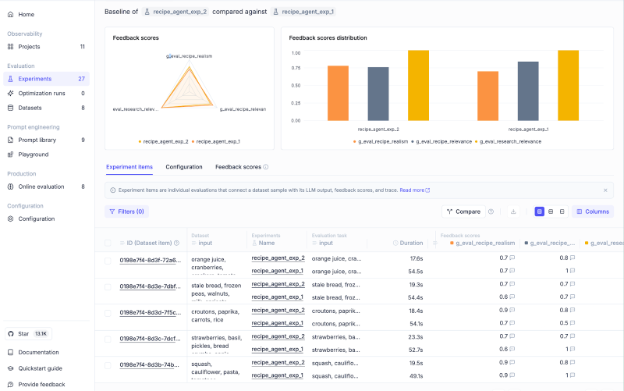>